<h3>Rebuild ENEM's answers<br></h3>

The enem's test with 45 single choice math questions, followed by alternatives ranging from A to E. In this scenario the last five answers have been removed from the test dataset, so you will rebuild them from the final average result - creating a model to predict the marked down answers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from src.send_answer import send_answer
from src.models.markov import Markov
from src.models.score import score, naive_approach

np.random.seed(42)
pd.set_option('display.max_columns', 500)

In [2]:
# input data
train = pd.read_csv('../../data/raw/train.csv', index_col=0).set_index('NU_INSCRICAO')
test = pd.read_csv('../../data/raw/test3.csv').set_index('NU_INSCRICAO')

# quick data clean-up
train.loc[:,'TX_RESPOSTAS_MT'] = train.loc[:,'TX_RESPOSTAS_MT'].str.replace('\.','*')
train = train.loc[train.TX_RESPOSTAS_MT.dropna(axis=0).index]

# remove the 0 scores from the training set
train = train.loc[train.NU_NOTA_MT != 0,:]

# reposition the training set
train = train[list(test.columns)+['TX_GABARITO_MT']]

train['group'], test['group'] = '', ''
train['PREDICTION'], test['PREDICTION'] = '', ''

<h3>Strategy</h3><br>
Considering the available options to choose from (A to E) and including the possibility to leave the question blank (*) the student last 5 answers would have a 1/7776 probability in a uniform distribution.<br><br> 

The strategy to overcome the dataset diversity consists on segmenting data in subsets in which the likelihood of similar answers gets increased. Not only using the test codes but utilizing `k_means` to analyze the previously filled answers to better define the subsets.

Additionally, a validation set will be taken from the train set to identify potential overfitting

In [3]:
train, validation = train_test_split(train, train_size=0.8, random_state=42)

codes = list(train['CO_PROVA_MT'].unique())

prev_answers_train = pd.DataFrame(list(map(lambda x: list(x), train.TX_RESPOSTAS_MT.str[:-5]))).set_index(train.index)
prev_answers_test = pd.DataFrame(list(map(lambda x: list(x), test.TX_RESPOSTAS_MT))).set_index(test.index)
prev_answers_validation = pd.DataFrame(list(map(lambda x: list(x), validation.TX_RESPOSTAS_MT.str[:-5]))).set_index(validation.index)

prev_answers_train['code'] = train['CO_PROVA_MT']
prev_answers_test['code'] = test['CO_PROVA_MT']
prev_answers_validation['code'] = validation['CO_PROVA_MT']

prev_answers = pd.concat([prev_answers_train, prev_answers_validation, prev_answers_test])
prev_answers['group'] = ''

c:\users\artur\envs\jornada-code-nation-enem\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
label_encod = LabelEncoder()
label_encod.fit(['A','B','C','D','E','*']);
prev_answers_enc = prev_answers.copy()
prev_answers_enc.iloc[:,:-2] = prev_answers_enc.iloc[:,:-2].apply(label_encod.transform)

**How to define the number of clusters?**  <a>Elbow method</a>

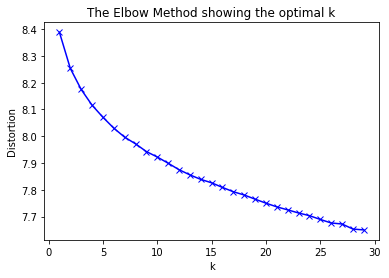

In [5]:
# k means determine k
distortions = []
code = codes[0]
X = prev_answers_enc.loc[prev_answers.code == code].iloc[:,:-2].values
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
k_clusters = 6

for code in codes:
    X = prev_answers_enc.loc[prev_answers.code == code].iloc[:,:-2].values
    kmeanModel = KMeans(n_clusters=k_clusters, init='random')
    kmeanModel.fit(X)
    prev_answers.loc[prev_answers.code == code,'group'] = kmeanModel.labels_

train.loc[:,'group'] = prev_answers.loc[train.index, 'group']
test.loc[:, 'group'] = prev_answers.loc[test.index, 'group']
validation.loc[:,'group'] = prev_answers.loc[validation.index, 'group']

<h3>Estimate</h3><br>
The underlying idea of the following function is to predict written answer for the segmented performance quartile as well as for its corresponding test using a Markov Chain.<br>

*Reference materials:*
<ol>
    <li><a href="https://www.youtube.com/watch?v=eGFJ8vugIWA">Coding Train - Markov Chains</a></li>
    <li><a href="http://setosa.io/ev/markov-chains/">Markov Chains Visually Explained</a></li>
</ol>

<br>Different from the other cases, this Markov Chain predicts all the answers at once, reducing the potential randomness in the results, however likely increasing overfitting


In [7]:
# set up the variables for the Markov Chains

# number of letters considered to train the Markov Chain (e.g. Reads the last three answer to predict the next)

order = 3
n_predictions = 5
shift = n_predictions + order

# iterate through all the math test codes
test_codes = prev_answers.code.unique()
for cod in test_codes:
    
    # iterate through the classified groups
    groups = prev_answers.group.unique()
    for group in groups:
       
        model = Markov(order, n_predictions)
        # train markov chain using each line
        
        train_set = train.loc[(train.CO_PROVA_MT == cod) & (train.group == group)]
        validation_set = validation.loc[(validation.CO_PROVA_MT == cod) & (validation.group == group)]
        test_set = test.loc[(test.CO_PROVA_MT == cod) & (test.group == group)]
        
        train_validation_test_set = pd.concat([
            train_set.loc[:,'TX_RESPOSTAS_MT'].str[-shift:-n_predictions], 
            validation_set.loc[:,'TX_RESPOSTAS_MT'].str[-order:],
            test_set.loc[:,'TX_RESPOSTAS_MT'].str[-order:]
        ])
        
        # assimilate all answers at once
        for i in train_set['TX_RESPOSTAS_MT'].str[-shift:]:
            model.train(i, multilple=False)
              
        for index, element in train_validation_test_set.iteritems():
            # build answer from empty string
            enem_answer = ''
            try:    
                enem_answer += model.predict(element)
            except KeyError or ValueError:
                for _ in range(n_predictions):
                    # In case it tries to make an unseen prediction, the result will be the mode on that position
                    enem_answer += train_set.loc[:, 'TX_RESPOSTAS_MT'].str[-n_predictions+len(enem_answer)].mode()[0]
            
            train_validation_test_set.loc[index] = enem_answer
        
        train.loc[train_set.index,'PREDICTION'] = train_validation_test_set.loc[train_set.index]
        validation.loc[validation_set.index,'PREDICTION'] = train_validation_test_set.loc[validation_set.index]
        test.loc[test_set.index,'PREDICTION'] = train_validation_test_set.loc[test_set.index]

print('Training set accuracy: %.2f' % (score(train.TX_RESPOSTAS_MT.str[-n_predictions:], train.PREDICTION)*100))
print('Validation set accuracy: %.2f' % (score(validation.TX_RESPOSTAS_MT.str[-n_predictions:], validation.PREDICTION)*100))

Training set accuracy: 50.00
Validation set accuracy: 24.84


Clearly overfitted

In [8]:
answer = test.copy().loc[:,['PREDICTION']]
answer = answer.rename(index=str, columns={"PREDICTION": "TX_RESPOSTAS_MT"})
#send_answer(answer.reset_index(), 3)